# Example: Cylinder Flow - Part 2/3

- Author: Dr. Daning Huang
- Date: 10/14/2025
- Updated: 12/08/2025

As discussed in Part 1, this part will train several models and visualize the predictions.  If you have gone through the previous examples, then the main new things here are two handy visualization tools.

## Setup

The imports:

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch

from dymad.io import load_model
from dymad.models import KBF, DKBF, DKMSK
from dymad.training import NODETrainer, LinearTrainer
from dymad.utils import animate, compare_contour, plot_summary, plot_trajectory, setup_logging

Model options:

In [2]:
def gen_mdl_kb(e, l, k):
    # Options for Koopman models
    return {
        "name" : 'vor_model',
        "encoder_layers" : e,
        "decoder_layers" : e,
        "latent_dimension" : l,
        "koopman_dimension" : k,
        "activation" : "prelu",
        "weight_init" : "xavier_uniform",
        "predictor_type" : "exp"}

mdl_kl = {  # Kernel model using Diffusion Map
    "name" : 'vor_model',
    "encoder_layers" : 0,
    "decoder_layers" : 0,
    "kernel_dimension" : 12,
    "type": "share",
    "kernel": {
        "type": "sc_dm",
        "input_dim": 12,
        "eps_init": None
    },
    "dtype": torch.float64,
    "ridge_init": 1e-10
    }

Training options:

In [3]:
# NODE trainer
trn_nd = {
    "n_epochs": 200,
    "save_interval": 50,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "sweep_lengths": [2],
    "sweep_epoch_step": 100,
    "chop_mode": "unfold",
    "chop_step": 1,
    "ode_method": "dopri5",
    "ode_args": {
        "rtol": 1.e-7,
        "atol": 1.e-9},
    "ls_update": {
        "method": "full",
        "interval": 50,
        "times": 1}
    }
# NODE trainer, for more nonlinear model
trn_ae = copy.deepcopy(trn_nd)
trn_ae["n_epochs"] = 2000
trn_ae["sweep_lengths"] = [2, 10, 50]
trn_ae["sweep_epoch_step"] = 500
trn_ae["ls_update"]["interval"] = 500
trn_ae["ls_update"]["times"] = 2
trn_ae["ls_update"]["reset"] = False
# Enable reconstruction loss
crit = {
    "dynamics" : {"weight" : 1.0},
    "recon" : {"weight" : 1.0}}
# Linear trainer using generic least squares
trn_ln = {
    "n_epochs": 500,
    "save_interval": 50,
    "load_checkpoint": False,
    "ls_update": {
        "method": "full"}
    }
# Linear trainer using linear solver given by model
## (Kernel Ridge Regression in this case)
trn_rw = copy.deepcopy(trn_ln)
trn_rw["ls_update"]["method"] = "raw"

Data transformation options:

In [4]:
# SVD for dimension reduction
## Used to save training cost
trn_svd = {
    "type" : "svd",
    "ifcen": True,
    "order": 12
}
# Normalize data by std
trn_scl = {
    "type" : "scaler",
    "mode" : "std",
}
# Appending unity to each sample
trn_add = {
    "type" : "add_one"
}
# Diffusion Map model
trn_dmf = {
    "type" : "dm",
    "edim": 3,
    "Knn" : 15,
    "Kphi": 3,
    "inverse": "gmls",
    "order": 1,
    "mode": "full"
}

The models to train:

- `kbf_node`: Continuous-time Koopman model, SVD as observables, using least squares and finite difference (for $\dot{z}$) to estimate system matrix and NODE to refine the matrix.
- `dkbf_ln`: Discrete-time (DT) Koopman model - equivalent to DMD.
- `dkbf_ae`: DT Koopman, but with an NN autoencoder to compress data further into 3 dimensions - this needs the longest training time among the models, but still fast.
- `dkbf_dm`: DT Koopman, using Diffusion Map to further reduce the dimensionality; but this reduction is nonlinear.
- `dks_ln`: A simple DT nonlinear model by Diffusion Map, plus skip-connection.  It is essentially a linear-regression type model, the data is normalized after SVD.

In [5]:
cfgs = [
    ('kbf_node', KBF,  NODETrainer,
     {"model": gen_mdl_kb(0,0,13), "criterion": crit, "training" : trn_nd, "transform_x" : [trn_svd, trn_add]}),
    ('dkbf_ln',  DKBF, LinearTrainer,
     {"model": gen_mdl_kb(0,0,13), "training" : trn_ln, "transform_x" : [trn_svd, trn_add]}),
    ('dkbf_ae',  DKBF, NODETrainer,
     {"model": gen_mdl_kb(3,64,3), "criterion": crit, "training" : trn_ae, "transform_x" : [trn_svd]}),
    ('dkbf_dm',  DKBF, LinearTrainer,
     {"model": gen_mdl_kb(0,0,3),  "training" : trn_ln, "transform_x" : [trn_svd, trn_dmf]}),
    ('dks_ln',  DKMSK, LinearTrainer,
     {"model": mdl_kl, "training" : trn_rw, "transform_x" : [trn_svd, trn_scl]}),
    ]
config_path = 'vor_model.yaml'

## Training

The usual work.

In [6]:
IDX = [0, 1, 2, 3, 4]

for i in IDX:
    mdl, MDL, Trainer, opt = cfgs[i]
    opt["model"]["name"] = f"kp_{mdl}"
    trainer = Trainer(config_path, MDL, config_mod=opt)
    trainer.train()

/Users/daninghuang/Repos/dymad-dev/src/dymad/training/ls_update.py:285: RuntimeWarning: divide by zero encountered in matmul
  avg_epoch_loss = np.linalg.norm(A @ W - b) / A.shape[0]
/Users/daninghuang/Repos/dymad-dev/src/dymad/training/ls_update.py:285: RuntimeWarning: overflow encountered in matmul
  avg_epoch_loss = np.linalg.norm(A @ W - b) / A.shape[0]
/Users/daninghuang/Repos/dymad-dev/src/dymad/training/ls_update.py:285: RuntimeWarning: invalid value encountered in matmul
  avg_epoch_loss = np.linalg.norm(A @ W - b) / A.shape[0]


## Visualization

First load reference dataset, and compute the model predictions.

In [7]:
dat = np.load('./data/cylinder.npz')
x_data, t_data = dat['x'], dat['t']
Nx, Ny = 199, 449

res = [x_data]
for i in IDX:
    mdl, MDL, Trainer, opt = cfgs[i]
    model, prd_func = load_model(MDL, f'kp_{mdl}.pt')
    with torch.no_grad():
        pred = prd_func(x_data, t_data)
    res.append(pred)

/Users/daninghuang/Repos/dymad-dev/src/dymad/numerics/dm.py:140: RuntimeWarning: divide by zero encountered in matmul
  eigvecs = Dinv1.reshape(-1,1) * (W @ self._psi_raw) / self._lmbd_raw
/Users/daninghuang/Repos/dymad-dev/src/dymad/numerics/dm.py:140: RuntimeWarning: overflow encountered in matmul
  eigvecs = Dinv1.reshape(-1,1) * (W @ self._psi_raw) / self._lmbd_raw
/Users/daninghuang/Repos/dymad-dev/src/dymad/numerics/dm.py:140: RuntimeWarning: invalid value encountered in matmul
  eigvecs = Dinv1.reshape(-1,1) * (W @ self._psi_raw) / self._lmbd_raw


In the function below, we introduce a `compare_contour` function.  It is a convenient tool to compare two 2D fields.  It generates 3 contours: One for truth, 2nd for prediction, 3rd for the error.

See the comments for the usage.

In [8]:
N = len(IDX)
def contour_fig(j):
    # A figure of Nx3 grid
    fig, ax = plt.subplots(N, 3, sharex=True, sharey=True, figsize=(12, 1.5*N))
    colorbar = j == 0
    for i in range(N):
        # Apply the function for each row of grid of axes
        compare_contour(
            res[0][j].reshape(Nx, Ny),     # Truth, at step j
            res[i+1][j].reshape(Nx, Ny),   # Prediction, at step j
            vmin=-12, vmax=12,             # Range of colorbar
            axes=(fig, ax[i]),             # The axes to plot the contours
            colorbar=colorbar)             # Whether to plot colorbar
        ax[i,1].set_title(cfgs[IDX[i]][0])
    for _ax in ax.flatten():               # Turn off axis for this case
        _ax.set_axis_off()
    return fig, ax

Below is the case for step 40.  All of them are doing a decent job.

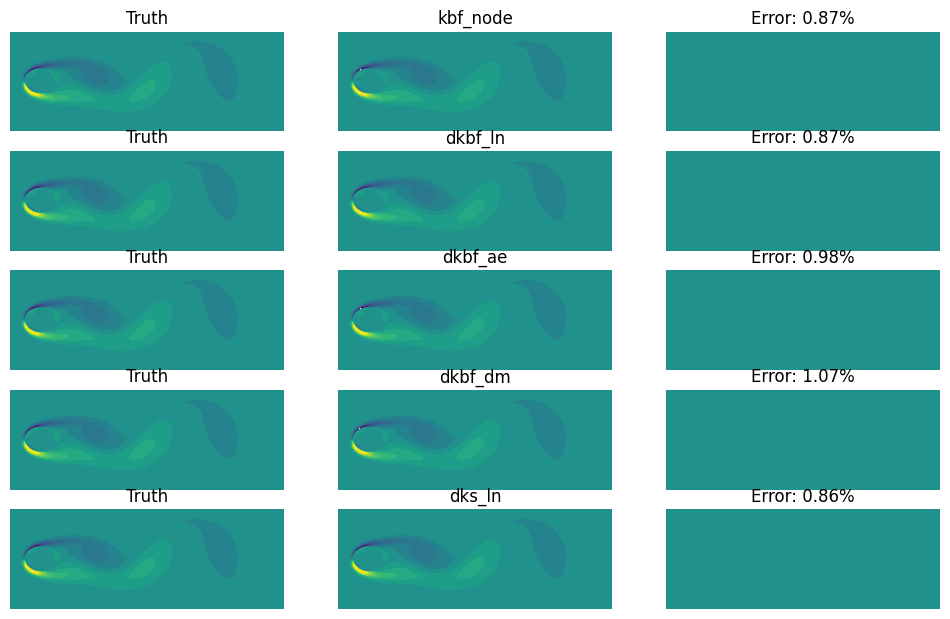

In [9]:
contour_fig(40);

One can further use `animate` to make an animation of the comparison over time.

The output is not shown here to save storage.  But feel free to try this locally.

In [10]:
setup_logging()            # Show progress
animate(
    contour_fig,           # The function for plotting
    filename="vis.mp4",    # Filename
    fps=10,                # Frame per second
    n_frames=len(t_data))  # Number of frames to plot